Define polytopic safe set
\begin{align*}
h_{\text{min}} & \le h \le h_{\text{max}}\\
v_{\text{min}} & \le v \le v_{\text{max}}\\
u_{\text{min}} & \le u \le u_{\text{max}}
\end{align*}

In [1]:
using Polyhedra
using CDDLib
function interval(i, bound)
    v = zeros(Int, 3)
    v[i] = 1
    HalfSpace(v, bound) ∩ HalfSpace(-v, bound)
end
function safeset(h, v, u)
    hr = interval(1, h) ∩ interval(2, v) ∩ interval(3, u)
    polyhedron(hr, CDDLibrary(:float))
end;

Define system
\begin{align*}
h_{k+1} & = h_k + v_k \Delta t\\
v_{k+1} & = v_k + u_k \Delta t
\end{align*}

In [2]:
using MathematicalSystems
using HybridSystems
using FillArrays
function reservoirsystem(p, Δt)
    A = [1. Δt  0;
         0   1 Δt;
         0   0  0]
    B = reshape([0, 0, 1.], 3, 1)
    G = HybridSystems.OneStateAutomaton(1)
    modes = Fill(ConstrainedDiscreteIdentitySystem(3, p), 1)
    Re = Fill(LinearControlDiscreteSystem(A, B), 1)
    Sw = Fill(AutonomousSwitching(), 1)
    hs = HybridSystem(G, modes, Re, Sw)
end;

Analytical solution for maximal controlled invariant set

In [3]:
sym(h, v) = convexhull([h, v], [-h, -v])
function mcis(hmax, vmax, umax, Δt)
    @assert hmax > 0
    @assert umax > 0
    @assert Δt > 0
    h = hmax
    v = 0.0
    vr = sym(h, v)
    λ = 1.0
    while λ == 1.0
        Δv = umax * Δt
        Δh = -(v + Δv) * Δt
        λ = min(1.0, (-hmax - h) / Δh, (vmax - v) / Δv)
        h += λ * Δh
        v += λ * Δv
        vr = convexhull(vr, sym(h, v))
    end
    if h + 1e-10 > -hmax
        vr = convexhull(vr, sym(-hmax, vmax))
    end
    polyhedron(vr, CDDLibrary(:float))
end;

Get an SDP solver

In [4]:
using MathOptInterfaceMosek
sdpoptimizer = MosekOptimizer(LOG=0);

Compute maximal volume ellipsoidal controlled invariant set

In [5]:
using SwitchOnSafety
const SOS = SwitchOnSafety
const MOI = MathOptInterface
function ellcis(hs, detcone = MOI.RootDetConeTriangle)
    getis(hs, sdpoptimizer, Fill(SOS.CenterPoint([0, 0, 0]), 1))[1]
end;

Plot the projection of the 3D ellipsoidal controlled invariant sets of dimensions $(h, v, u)$ into $(h, v)$

In [52]:
using Plots
pyplot()
include("colors.jl")

function proj(ell, I)
    Qd = inv(ell.Q)
    Qdproj = Qd[I, I]
    Qproj = inv(Qdproj)
    SOS.Ellipsoid(Qproj, ell.c[I])
end
function plotsets(p, S, P=nothing; I=[1, 2])
    plot(project(p, I), color=lichen, ticks=nothing, border=nothing)
    Plots.plot!(S, fillalpha=1.0, color=aurore)
    if P !== nothing
        Plots.plot!(proj(P, I), fillalpha=1.0, color=canard)
    end
    Plots.plot!() # return
end;

Put everything together

In [16]:
function reservoir(h, v, u, Δt; ell=true, kws...)
    p = safeset(h, v, u)
    hs = reservoirsystem(p, Δt)
    S = mcis(h, v, u, Δt)
    if ell
        P = ellcis(hs)
        plotsets(p, S, P; kws...)
    else
        plotsets(p, S; kws...)
    end
end;

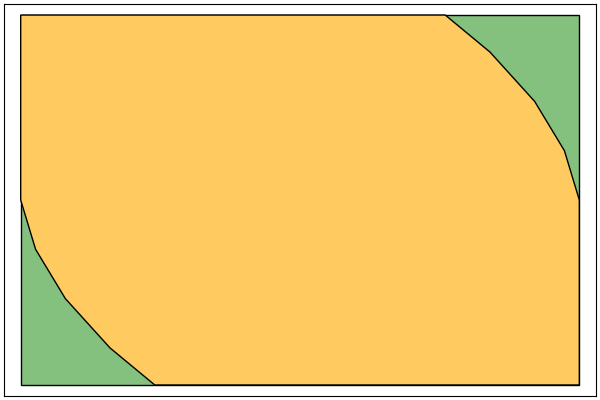

In [53]:
reservoir(3, 1.5, 1, 0.4, ell=false)

MOI.get(model, MOI.SolveTime()) = 0.002928018569946289
JuMP.terminationstatus(model) = Success::MathOptInterface.TerminationStatusCode = 0
JuMP.primalstatus(model) = FeasiblePoint::MathOptInterface.ResultStatusCode = 0
JuMP.dualstatus(model) = FeasiblePoint::MathOptInterface.ResultStatusCode = 0
JuMP.objectivevalue(model) = 2.322717873504099


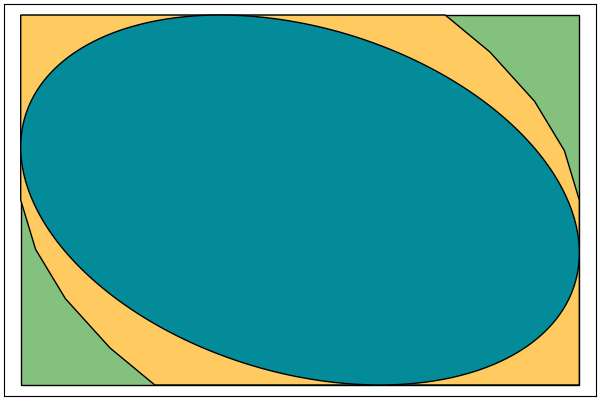

In [54]:
reservoir(3, 1.5, 1, 0.4)